In [2]:
!pip install gymnasium[atari,accept-rom-license]==0.29.1

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
# These are the recommended hyperparameters
class Hyperparameters:
    env_id = "BreakoutNoFrameskip-v4"
    exp_name = "DQN_Breakout"
    seed = 1
    torch_deterministic = True
    capture_video = True
    save_model = True

    total_timesteps = 10_000_000
    learning_rate = 1e-4
    buffer_size = 400_000
    gamma = 0.95
    tau = 1
    target_network_frequency = 1000
    batch_size = 128
    start_e = 1
    end_e = 0.01
    exploration_fraction = 0.05
    learning_starts = 80_000
    train_frequency = 4
    total_timesteps = 10000000

In [8]:
params = Hyperparameters()
print(params.env_id)


BreakoutNoFrameskip-v4


In [9]:
import os
import random
import time

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Imports all our hyperparameters from the other file
#from hyperparams_A import Hyperparameters as params
#from hyperparams_B import Hyperparameters as params
#from hyperparams_C import Hyperparameters as params
#from hyperparams_D import Hyperparameters as params
#from hyperparams_E import Hyperparameters as params
#import Hyperparameters as params

In [10]:
for key, value in vars(params).items():
    print(f"{key}: {value}")

In [11]:
pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [12]:
# stable_baselines3 have wrappers that simplifies
# the preprocessing a lot, read more about them here:
# https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
# Creates our gym environment and with all our wrappers.
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                #env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
                 video_path = f"/content/drive/MyDrive/videos/{run_name}"
                 env = gym.wrappers.RecordVideo(env, video_path)

        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [15]:
class QNetwork(nn.Module):
    def __init__(self, env,in_channels):
        super().__init__()
        # TODO: #Done Define your network (agent)
        # Look at Section 4.1 in the paper for help: https://arxiv.org/pdf/1312.5602v1.pdf

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=4, stride=2),
            nn.ReLU(),
        )

        conv_output_size = self.get_conv_output_size(in_channels)
        self.output_layer = nn.Linear(conv_output_size, env.single_action_space.n)

    def forward(self, x):
        #return self.network(x / 255.0)
        x = self.network(x)
        x = x.view(x.size(0), -1)  # Flatten the output from convolutional layers
        x = self.output_layer(x)
        return x

    def get_conv_output_size(self, input_channels):
        input_tensor = torch.rand(1, input_channels, 84, 84)
        conv_output = self.network(input_tensor)
        conv_output_size = conv_output.view(conv_output.size(0), -1).size(1)
        return conv_output_size

In [16]:
!pip install ale-py

In [17]:

!pip install gymnasium[atari] ale-py

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time

# Use gymnasium for modern environments
import gymnasium as gym

# Ensure stable_baselines3 wrappers are used (they work well with gymnasium)
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)

# Import ReplayBuffer for experience replay
from stable_baselines3.common.buffers import ReplayBuffer

# Import Atari environments (this ensures they're registered properly)
try:
    import gymnasium.envs.atari
    print("Successfully imported gymnasium.envs.atari")
except ImportError:
    print("Could not import gymnasium.envs.atari. Ensure ale-py is installed.")



# Define a helper to linearly decay epsilon for exploration
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

# ✅ Environment construction with correct wrappers
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        # Ensure video recording is possible by setting the correct render mode
        env = gym.make(env_id, render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)

        if capture_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}", name_prefix=env_id)

        # Apply common Atari wrappers
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)

        return env
    return thunk

# ✅ Q-Network architecture
class QNetwork(nn.Module):
    def __init__(self, env, in_channels):
        super().__init__()
        # Based on DQN paper architecture (3 conv layers)
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Calculate the output size of the conv layers
        conv_output_size = self.get_conv_output_size(in_channels)
        self.output_layer = nn.Linear(conv_output_size, env.single_action_space.n)

    def forward(self, x):
        x = x / 255.0  # Normalize pixel values
        x = self.network(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.output_layer(x)
        return x

    def get_conv_output_size(self, input_channels):
        # Simulate a forward pass to determine the size
        input_tensor = torch.rand(1, input_channels, 84, 84)
        conv_output = self.network(input_tensor)
        return conv_output.view(1, -1).size(1)

# ✅ Setup and initialization
run_name = f"{params.env_id}__{params.exp_name}__{params.seed}__{int(time.time())}"

# Set random seeds for reproducibility
random.seed(params.seed)
np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.backends.cudnn.deterministic = params.torch_deterministic

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time

# Use gymnasium for modern environments
import gymnasium as gym

# Ensure stable_baselines3 wrappers are used (they work well with gymnasium)
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)

# Import ReplayBuffer for experience replay
from stable_baselines3.common.buffers import ReplayBuffer

# Import Atari environments (this ensures they're registered properly)
try:
    import gymnasium.envs.atari
    print("Successfully imported gymnasium.envs.atari")
except ImportError:
    print("Could not import gymnasium.envs.atari. Ensure ale-py is installed.")

# Set up your parameters (replace this with argparse or your actual parameter class)
class Params:
    env_id = "BreakoutNoFrameskip-v4"
    seed = 1
    exp_name = "dqn_test"
    capture_video = True
    seed = 1
    torch_deterministic = True
    capture_video = True
    save_model = True
    learning_rate = 1e-4
    buffer_size = 10000
    torch_deterministic = True
    total_timesteps = 10000000
    torch_deterministic = True
    capture_video = True
    save_model = True

    total_timesteps = 10_000_000
    learning_rate = 1e-4
    buffer_size = 400_000
    gamma = 0.95
    tau = 1
    target_network_frequency = 1000
    batch_size = 128
    start_e = 1
    end_e = 0.01
    exploration_fraction = 0.05
    learning_starts = 80_000
    train_frequency = 4
    total_timesteps = 100000
params = Params()

# Define a helper to linearly decay epsilon for exploration
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

# ✅ Environment construction with correct wrappers
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        # Ensure video recording is possible by setting the correct render mode
        env = gym.make(env_id, render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)

        if capture_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}", name_prefix=env_id)

        # Apply common Atari wrappers
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)

        return env
    return thunk

# ✅ Q-Network architecture
class QNetwork(nn.Module):
    def __init__(self, env, in_channels):
        super().__init__()
        # Based on DQN paper architecture (3 conv layers)
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Calculate the output size of the conv layers
        conv_output_size = self.get_conv_output_size(in_channels)
        self.output_layer = nn.Linear(conv_output_size, env.single_action_space.n)

    def forward(self, x):
        x = x / 255.0  # Normalize pixel values
        x = self.network(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.output_layer(x)
        return x

    def get_conv_output_size(self, input_channels):
        # Simulate a forward pass to determine the size
        input_tensor = torch.rand(1, input_channels, 84, 84)
        conv_output = self.network(input_tensor)
        return conv_output.view(1, -1).size(1)

# ✅ Setup and initialization
run_name = f"{params.env_id}__{params.exp_name}__{params.seed}__{int(time.time())}"

# Set random seeds for reproducibility
random.seed(params.seed)
np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.backends.cudnn.deterministic = params.torch_deterministic

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create vectorized environment
envs = gym.vector.SyncVectorEnv([make_env(params.env_id, params.seed, 0, params.capture_video, run_name)])

Could not import gymnasium.envs.atari. Ensure ale-py is installed.
Could not import gymnasium.envs.atari. Ensure ale-py is installed.


In [20]:
run_name = f"{params.env_id}__{params.exp_name}__{params.seed}__{int(time.time())}"

random.seed(params.seed)
np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.backends.cudnn.deterministic = params.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # env setup
envs = gym.vector.SyncVectorEnv([make_env(params.env_id, params.seed, 0, params.capture_video, run_name)])
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

from gymnasium.wrappers import RecordEpisodeStatistics
#from gymnasium.vector import SyncVectorEnv


envs = RecordEpisodeStatistics(envs)


q_network = QNetwork(envs, 4).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=params.learning_rate)
target_network = QNetwork(envs,4).to(device)
target_network.load_state_dict(q_network.state_dict())

# We’ll be using experience replay memory for training our DQN.
# It stores the transitions that the agent observes, allowing us to reuse this data later.
# By sampling from it randomly, the transitions that build up a batch are decorrelated.
# It has been shown that this greatly stabilizes and improves the DQN training procedure.
rb = ReplayBuffer(
    params.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    optimize_memory_usage=False,
    handle_timeout_termination=True,
)

obs = envs.reset()

/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_action_space` for environment variables or `env.get_wrapper_attr('single_action_space')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_action_space` for environment variables or `env.get_wrapper_attr('single_action_space')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.un

In [22]:
obs_raw = envs.reset(seed=1)
print("obs_raw:", obs_raw)
print("Type of obs_raw:", type(obs_raw))
if isinstance(obs_raw, (list, tuple)):
    print(f"Length: {len(obs_raw)}")
    print("Types and shapes of elements:")
    for i, el in enumerate(obs_raw):
        print(f"Element {i}: type={type(el)}")
        if isinstance(el, dict):
            for k, v in el.items():
                print(f"  key='{k}', type={type(v)}, shape={getattr(v, 'shape', 'N/A')}")
        elif isinstance(el, (np.ndarray, list)):
            try:
                print(f"  shape={np.array(el).shape}")
            except:
                print("  cannot get shape")
else:
    print("obs_raw is not a list or tuple")


obs_raw: (array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8), {})
Type of obs_raw: <class 'tuple'>
Length: 2
Types and shapes of elements:
Element 0: type=<c

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

episodic_returns = []  # Initialize list to store episodic returns
episode_num = 0

# Reset env and convert obs to np.array if needed
obs, _ = envs.reset()

for global_step in range(params.total_timesteps):
    # Get epsilon for epsilon-greedy
    epsilon = linear_schedule(
        params.start_e,
        params.end_e,
        params.exploration_fraction * params.total_timesteps,
        global_step
    )

    if random.random() < epsilon:
        # Sample random action for all parallel envs
        actions = envs.action_space.sample()  # shape: (num_envs,)
    else:
        #obs_tensor = torch.tensor(obs, dtype=torch.float32).permute(0, 3, 1, 2).to(device)  # NCHW
         obs_tensor = torch.tensor(obs, dtype=torch.float32)
         if obs_tensor.ndim == 4 and obs_tensor.shape[1] not in [1, 3, 4]:  # heuristic
           obs_tensor = obs_tensor.permute(0, 3, 1, 2)
         obs_tensor = obs_tensor.to(device)

         with torch.no_grad():
            q_values = q_network(obs_tensor)
            actions = torch.argmax(q_values, dim=1).cpu().numpy()  # shape: (num_envs,)

    # Take step
    next_obs, rewards, terminateds, truncateds, infos = envs.step(actions)
    # Convert next_obs to np.array if needed
    if isinstance(next_obs, (tuple, list)):
        next_obs = np.array(next_obs)

    dones = np.logical_or(terminateds, truncateds)

    if not isinstance(infos, list):
        infos = [infos]

    for idx, info_dict in enumerate(infos):
      #print(f"Env {idx} done={dones[idx]}, info={info_dict}")
      if isinstance(info_dict, dict) and "episode" in info_dict:
        print(f"global_step={global_step}, episodic_return={info_dict['episode']['r']}")


    # Log episodic return if any env finished
    for info_dict in infos:
        if isinstance(info_dict, dict) and "episode" in info_dict:
            print(f"global_step={global_step}, episodic_return={info_dict['episode']['r']}")
            episodic_return = info_dict["episode"]["r"]
            episodic_returns.append(episodic_return)
            print(f"global_step={global_step}, episodic_return={episodic_return}")
            #break

    # Prepare real_next_obs to handle terminal observations properly
    real_next_obs = next_obs.copy()  # copy numpy array
    obs_shape = obs.shape[1:]  # shape of single observation (H, W, C)

    for idx, done in enumerate(dones):
        if done and idx < len(infos) and isinstance(infos[idx], dict) and "terminal_observation" in infos[idx]:
            term_obs = np.array(infos[idx]["terminal_observation"])
            # Check shape, replace with zeros if mismatch
            if term_obs.shape != obs_shape:
                real_next_obs[idx] = np.zeros(obs_shape, dtype=term_obs.dtype)
            else:
                real_next_obs[idx] = term_obs

    # Add transition to replay buffer
    rb.add(
        obs,             # shape (num_envs, H, W, C)
        real_next_obs,    # same shape as obs
        np.array(actions),
        np.array(rewards),
        np.array(dones),
        infos
    )

    # Update current observation
    obs = next_obs

    # Training step
    if global_step > params.learning_starts:
        if global_step % params.train_frequency == 0:
            data = rb.sample(params.batch_size)

            with torch.no_grad():
                next_obs_tensor = data.next_observations.to(torch.float32)
                if next_obs_tensor.ndim == 4 and next_obs_tensor.shape[1] != 4:
                    next_obs_tensor = next_obs_tensor.permute(0, 3, 1, 2)
                next_q_values = target_network(next_obs_tensor.to(device))
                target_max, _ = torch.max(next_q_values, dim=1)
                td_target = data.rewards.to(device) + params.gamma * (1 - data.dones.to(device).float()) * target_max

            current_obs_tensor = data.observations.to(torch.float32)
            if current_obs_tensor.ndim == 4 and current_obs_tensor.shape[1] != 4:
                current_obs_tensor = current_obs_tensor.permute(0, 3, 1, 2)
            current_q_values = q_network(current_obs_tensor.to(device))
            #actions_tensor = data.actions.to(device).long()
            #old_val = current_q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze()
            #old_val = current_q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(-1)
            actions_tensor = data.actions.to(device).long()
            if actions_tensor.dim() > 1:
              actions_tensor = actions_tensor.squeeze()
            old_val = current_q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(-1)


            loss = F.mse_loss(old_val, td_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Soft update target network
        if global_step % params.target_network_frequency == 0:
            for target_param, q_param in zip(target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(
                    params.tau * q_param.data + (1.0 - params.tau) * target_param.data
                )


global_step=13, episodic_return=[0.]
global_step=13, episodic_return=[0.]
global_step=13, episodic_return=[0.]
global_step=34, episodic_return=[0.]
global_step=34, episodic_return=[0.]
global_step=34, episodic_return=[0.]
global_step=103, episodic_return=[1.]
global_step=103, episodic_return=[1.]
global_step=103, episodic_return=[1.]
global_step=126, episodic_return=[0.]
global_step=126, episodic_return=[0.]
global_step=126, episodic_return=[0.]


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-0.mp4.
Moviepy - Writing video /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-0.mp4
global_step=149, episodic_return=[0.]
global_step=149, episodic_return=[0.]
global_step=149, episodic_return=[0.]
global_step=172, episodic_return=[0.]
global_step=172, episodic_return=[0.]
global_step=172, episodic_return=[0.]
global_step=195, episodic_return=[0.]
global_step=195, episodic_return=[0.]
global_step=195, episodic_return=[0.]
global_step=218, episodic_return=[0.]
global_step=218, episodic_return=[0.]
global_step=218, episodic_return=[0.]
global_step=241, episodic_return=[0.]
global_step=241, episodic_return=[0.]
global_step=241, episodic_return=[0.]
Moviepy - Building video /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-1.mp4.
Moviepy - Writing video /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-1.mp4
global_step=264, episodic_return=[0.]
global_step=264, episodic_return=[0.]
global_step=264, episodic_return=[0.]
global_step=287, episodic_return=[0.]
global_step=287, episodic_return=[0.]
global_step=287, episodic_return=[0.]
global_step=383, episodic_return=[2.]
global_step=383, episodic_return=[2.]
global_step=383, episodic_return=[2.]
global_step=406, episodic_return=[0.]
global_step=406, episodic_return=[0.]
global_step=406, episodic_return=[0.]
global_step=429, episodic_return=[0.]
global_step=429, episodic_return=[0.]
global_step=429, episodic_return=[0.]
global_step=452, episodic_return=[0.]
global_step=452, episodic_return=[0.]
global_step=452, episodic_return=[0.]
global_step=475, episodic_return=[0.]
global_step=475, episodic_return=[0.]
global_step=475, episodic_return=[0.]
global_step=498, episodic_return=[0.]
global_step=498, episodi

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-8.mp4
global_step=1499, episodic_return=[0.]
global_step=1499, episodic_return=[0.]
global_step=1499, episodic_return=[0.]
global_step=1522, episodic_return=[0.]
global_step=1522, episodic_return=[0.]
global_step=1522, episodic_return=[0.]
global_step=1545, episodic_return=[0.]
global_step=1545, episodic_return=[0.]
global_step=1545, episodic_return=[0.]
global_step=1568, episodic_return=[0.]
global_step=1568, episodic_return=[0.]
global_step=1568, episodic_return=[0.]
global_step=1591, episodic_return=[0.]
global_step=1591, episodic_return=[0.]
global_step=1591, episodic_return=[0.]
global_step=1612, episodic_return=[0.]
global_step=1612, episodic_return=[0.]
global_step=1612, episodic_return=[0.]
global_step=1635, episodic_return=[0.]
global_step=1635, episodic_return=[0.]
global_step=1635, episodic_return=[0.]
global_step=1658, episodic_return=[0.]
gl

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-27.mp4
global_step=4441, episodic_return=[0.]
global_step=4441, episodic_return=[0.]
global_step=4441, episodic_return=[0.]
global_step=4464, episodic_return=[0.]
global_step=4464, episodic_return=[0.]
global_step=4464, episodic_return=[0.]
global_step=4487, episodic_return=[0.]
global_step=4487, episodic_return=[0.]
global_step=4487, episodic_return=[0.]
global_step=4585, episodic_return=[2.]
global_step=4585, episodic_return=[2.]
global_step=4585, episodic_return=[2.]
global_step=4656, episodic_return=[1.]
global_step=4656, episodic_return=[1.]
global_step=4656, episodic_return=[1.]
global_step=4728, episodic_return=[1.]
global_step=4728, episodic_return=[1.]
global_step=4728, episodic_return=[1.]
global_step=4751, episodic_return=[0.]
global_step=4751, episodic_return=[0.]
global_step=4751, episodic_return=[0.]
global_step=4774, episodic_return=[0.]
g

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-64.mp4
global_step=10203, episodic_return=[0.]
global_step=10203, episodic_return=[0.]
global_step=10203, episodic_return=[0.]
global_step=10226, episodic_return=[0.]
global_step=10226, episodic_return=[0.]
global_step=10226, episodic_return=[0.]
global_step=10295, episodic_return=[1.]
global_step=10295, episodic_return=[1.]
global_step=10295, episodic_return=[1.]
global_step=10367, episodic_return=[1.]
global_step=10367, episodic_return=[1.]
global_step=10367, episodic_return=[1.]
global_step=10438, episodic_return=[1.]
global_step=10438, episodic_return=[1.]
global_step=10438, episodic_return=[1.]
global_step=10510, episodic_return=[1.]
global_step=10510, episodic_return=[1.]
global_step=10510, episodic_return=[1.]
global_step=10533, episodic_return=[0.]
global_step=10533, episodic_return=[0.]
global_step=10533, episodic_return=[0.]
global_step=10556, 

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-125.mp4
global_step=20094, episodic_return=[1.]
global_step=20094, episodic_return=[1.]
global_step=20094, episodic_return=[1.]
global_step=20117, episodic_return=[0.]
global_step=20117, episodic_return=[0.]
global_step=20117, episodic_return=[0.]
global_step=20140, episodic_return=[0.]
global_step=20140, episodic_return=[0.]
global_step=20140, episodic_return=[0.]
global_step=20163, episodic_return=[0.]
global_step=20163, episodic_return=[0.]
global_step=20163, episodic_return=[0.]
global_step=20186, episodic_return=[0.]
global_step=20186, episodic_return=[0.]
global_step=20186, episodic_return=[0.]
global_step=20209, episodic_return=[0.]
global_step=20209, episodic_return=[0.]
global_step=20209, episodic_return=[0.]
global_step=20232, episodic_return=[0.]
global_step=20232, episodic_return=[0.]
global_step=20232, episodic_return=[0.]
global_step=20255,

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-216.mp4
global_step=37000, episodic_return=[0.]
global_step=37000, episodic_return=[0.]
global_step=37000, episodic_return=[0.]
global_step=37023, episodic_return=[0.]
global_step=37023, episodic_return=[0.]
global_step=37023, episodic_return=[0.]
global_step=37046, episodic_return=[0.]
global_step=37046, episodic_return=[0.]
global_step=37046, episodic_return=[0.]
global_step=37069, episodic_return=[0.]
global_step=37069, episodic_return=[0.]
global_step=37069, episodic_return=[0.]
global_step=37092, episodic_return=[0.]
global_step=37092, episodic_return=[0.]
global_step=37092, episodic_return=[0.]
global_step=37115, episodic_return=[0.]
global_step=37115, episodic_return=[0.]
global_step=37115, episodic_return=[0.]
global_step=37138, episodic_return=[0.]
global_step=37138, episodic_return=[0.]
global_step=37138, episodic_return=[0.]
global_step=37236,

Moviepy - Done !
Moviepy - video ready /content/videos/BreakoutNoFrameskip-v4__dqn_test__1__1748596881/BreakoutNoFrameskip-v4-episode-343.mp4
global_step=59640, episodic_return=[0.]
global_step=59640, episodic_return=[0.]
global_step=59640, episodic_return=[0.]
global_step=59663, episodic_return=[0.]
global_step=59663, episodic_return=[0.]
global_step=59663, episodic_return=[0.]
global_step=59686, episodic_return=[0.]
global_step=59686, episodic_return=[0.]
global_step=59686, episodic_return=[0.]
global_step=59709, episodic_return=[0.]
global_step=59709, episodic_return=[0.]
global_step=59709, episodic_return=[0.]
global_step=59732, episodic_return=[0.]
global_step=59732, episodic_return=[0.]
global_step=59732, episodic_return=[0.]
global_step=59755, episodic_return=[0.]
global_step=59755, episodic_return=[0.]
global_step=59755, episodic_return=[0.]
global_step=59778, episodic_return=[0.]
global_step=59778, episodic_return=[0.]
global_step=59778, episodic_return=[0.]
global_step=59801,

<ipython-input-23-ca67917a9dbd>:111: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(old_val, td_target)


global_step=80009, episodic_return=[0.]
global_step=80009, episodic_return=[0.]
global_step=80009, episodic_return=[0.]
global_step=80030, episodic_return=[0.]
global_step=80030, episodic_return=[0.]
global_step=80030, episodic_return=[0.]
global_step=80053, episodic_return=[0.]
global_step=80053, episodic_return=[0.]
global_step=80053, episodic_return=[0.]
global_step=80076, episodic_return=[0.]
global_step=80076, episodic_return=[0.]
global_step=80076, episodic_return=[0.]
global_step=80099, episodic_return=[0.]
global_step=80099, episodic_return=[0.]
global_step=80099, episodic_return=[0.]
global_step=80120, episodic_return=[0.]
global_step=80120, episodic_return=[0.]
global_step=80120, episodic_return=[0.]
global_step=80171, episodic_return=[1.]
global_step=80171, episodic_return=[1.]
global_step=80171, episodic_return=[1.]
global_step=80192, episodic_return=[0.]
global_step=80192, episodic_return=[0.]
global_step=80192, episodic_return=[0.]
global_step=80215, episodic_return=[0.]


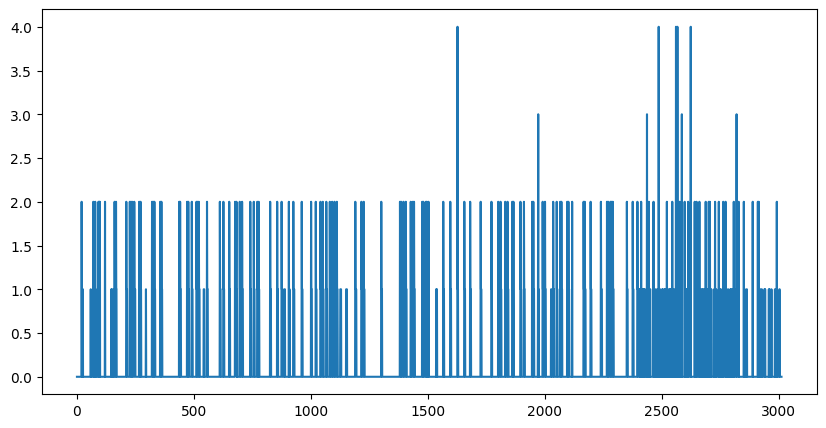

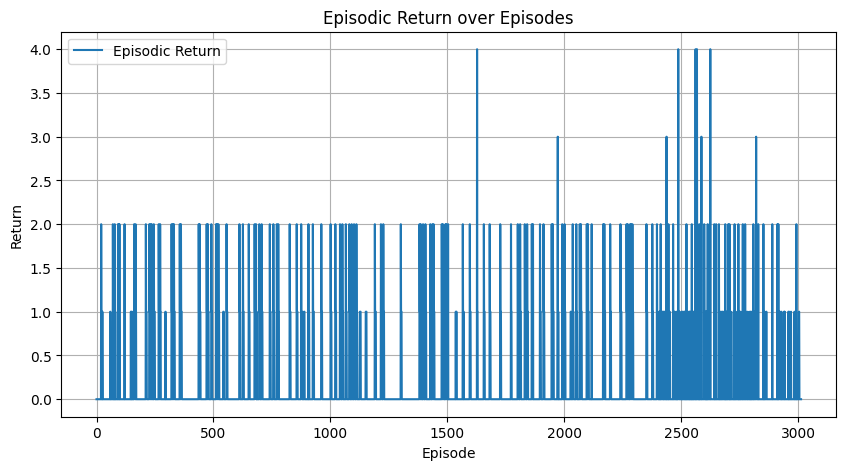

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(episodic_returns, label="Episodic Return")
plt.figure(figsize=(10, 5))
plt.plot(episodic_returns, label="Episodic Return", linestyle='-', marker='')  # Line graph with no markers
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Episodic Return over Episodes")
plt.grid(True)

plt.legend()
plt.show()

In [ ]:
window = 50
moving_avg = np.convolve(episodic_returns, np.ones(window)/window, mode='valid')
plt.plot(moving_avg)
plt.title(f"{window}-Episode Moving Average of Return")

## Comment on Runs

### <font color="red"> BreakoutNoFrameskip-v4__DQN_Breakout__A</font>

<font color="blue">
Default hyperparameters<br>
Decreased buffer size to 100.000 due to  memory restrictions<br>
We stopped the loop early as the agent seems to have converged to a sub optimal policy<br>
</font>

Best-performing videos are

rl-video-episode-3000.mp4
and
rl-video-episode-5000.mp4

which achieve a score of 59

after that the agent becomes unstable until in after global-step ~700.000 it seems to be locked into a very low performance



### <font color="red"> BreakoutNoFrameskip-v4__DQN_Breakout__B</font>

<font color="blue">
Compared to Run A <br>
Set buffer size to 200.000 vs 100.000<br>
Set end_e = 0.05 from 0.01
set exploration factor to 0.2 from 0.1
</font>

If we look into the glob-step vs episodic return we see than initially the performance seems to be very similar to run A (even a bit better at around steps 100.000-150.000) but after that ther is a sudden catastrophic forgetting happens around step 175.000.
the performance seems to incease afterwards but slowly so we stopped due to time restrictions

### <font color="red"> BreakoutNoFrameskip-v4__DQN_Breakout__C</font>

<font color="blue">
Same hyper parameters with Run A <br>
Set buffer size to 200.000 from 100.000<br>
</font>

following the same initial learning as in in run A the performance seems to reach higher levels at approximately step 1.000.000 and after but the first instability also appears sooner at arrpoximately step 1.650.000.

### <font color="red"> BreakoutNoFrameskip-v4__DQN_Breakout__D</font>

<font color="blue">
Same hyper parameters with Run C <br>
but set exploration fraction to 0.333 from 0.1<br>
</font>

The increase of average episodic return is too slow<br>
at step ~1.300.000 100-rolling average episodic return is around 5 while in run A it was approximately 45<br>
stopped due to time constraints

### <font color="red"> BreakoutNoFrameskip-v4__DQN_Breakout__E</font>

<font color="blue">
Same hyper parameters with Run C <br>
tried decreasing exloration factor to 0.08 from 0.1<br>
tried decreasing end_e to 0.05 from 0.1<br>
</font>

The model learns a bit faster than C (in terms of episodes) but suffers from<br>
same instabiility even while not reaching as high rolling average epsodic returns

### <font color="red"> BreakoutNoFrameskip-v4__DQN_Breakout__F</font>

<font color="blue">
Same hyper parameters with Run C <br>
increased buffe size to 400.000<br>
decreased discount factor gamma to 0.95 from 0.99<br>
decreased exploration factor to 0.05 from 0.1<br>
</font>

The learning seems to be more stable, we do not observe sudden catastrophic<br>
forgetting with extremely low episodic returns<br>
<br>
Learning starts earlier in terms of episodes and has a clear upwards trend<br>
Since the average peisodic return for stays relatively high across the<br> training, the trainig time is considerably larger. We reached 5000 episodes<br>
and approcemately 4.5m time step only after running for several days on a simple laptop